# End of module project

Uses the tennis matches results data between 2020 and 2022 from http://tennis-data.co.uk/alldata.php



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

df = pd.read_csv('./2020-2022.csv')
df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Bublik A.,...,0.0,Completed,2.00,1.72,2.21,1.74,2.25,1.80,2.11,1.72
1,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,...,0.0,Completed,1.57,2.25,1.60,2.47,1.65,2.47,1.59,2.34
2,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,...,0.0,Completed,1.25,3.75,1.31,3.74,1.33,3.85,1.29,3.53
3,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,...,1.0,Completed,1.83,1.83,1.97,1.92,2.00,2.07,1.87,1.92
4,1,Doha,Qatar Exxon Mobil Open,1/6/2020,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,...,1.0,Completed,1.50,2.50,1.54,2.62,1.57,2.65,1.53,2.47


In [2]:
print(df.shape)
# drop the lines where there are no data in AvgW, AvgL, WRank or LRank
df = df.dropna(subset=['AvgW','AvgL','WRank','LRank'],axis=0)
print(df.shape)
# drop the lines where AvgW ou AvgL are dubious (more than 50% away from B365W / B365L)
df = df.drop(df[df['AvgW']>1.5*df['B365W']].index,axis=0)
df = df.drop(df[df['AvgL']>1.5*df['B365L']].index,axis=0)
print(df.shape)

df = df.reset_index(drop=True)
# compute delta rank
df['DeltaRank'] = df['WRank']-df['LRank']

(4354, 36)
(4339, 36)
(4329, 36)


## 0. How reliable are the odds?

In [3]:
# odds are ok if winner's was lower than loser's
diff = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
res = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = df[abs(df['AvgL']-df['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    res[i] = ok.size/df2.size*100
    i=i+1

In [4]:
# do the same but for ATP250 tournaments
subdf = df[df['Series']=="ATP250"]
res250 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    res250[i] = ok.size/df2.size*100
    i=i+1

In [5]:
# do the same but for ATP500 tournaments
subdf = df[df['Series']=="ATP500"]
res500 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    res500[i] = ok.size/df2.size*100
    i=i+1

In [6]:
# do the same but for Masters 1000 tournaments
subdf = df[df['Series']=="Masters 1000"]
res1000 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    res1000[i] = ok.size/df2.size*100
    i=i+1

In [7]:
# do the same but for Grand Slam tournaments
subdf = df[df['Series']=="Grand Slam"]
resGS = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS[i] = ok.size/df2.size*100
    i=i+1

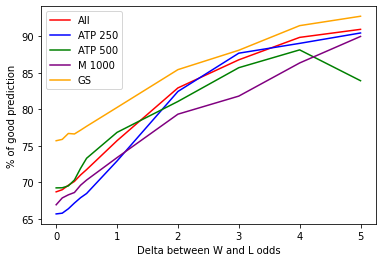

In [8]:

plt.plot(diff,res,color = 'red',label='All')
plt.plot(diff,res250,color = 'blue',label='ATP 250')
plt.plot(diff,res500,color = 'green',label='ATP 500')
plt.plot(diff,res1000,color = 'purple',label='M 1000')
plt.plot(diff,resGS,color = 'orange',label='GS')
plt.xlabel("Delta between W and L odds")
plt.ylabel("% of good prediction")
plt.legend()
plt.show()

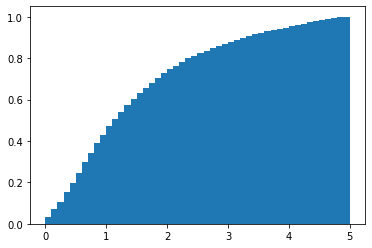

In [9]:
subdf = df[abs(df['AvgL']-df['AvgW'])<=5]
plt.hist(abs(subdf['AvgL']-subdf['AvgW']),bins=50,cumulative=True,density=True)
plt.show()

### Grand slams per round

In [10]:
#  GRand Slam tournaments
sdf = df[df['Series']=="Grand Slam"]
subdf = sdf[sdf['Round']=="1st Round"]
resGS1 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS1[i] = ok.size/df2.size*100
    i=i+1

In [11]:
subdf = sdf[sdf['Round']=="2nd Round"]
resGS2 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS2[i] = ok.size/df2.size*100
    i=i+1

In [12]:
subdf = sdf[sdf['Round']=="3rd Round"]
resGS3 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS3[i] = ok.size/df2.size*100
    i=i+1

In [13]:
subdf = sdf[sdf['Round']=="4th Round"]
resGS4 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS4[i] = ok.size/df2.size*100
    i=i+1

In [14]:
subdf = sdf[sdf['Round']=="Quarterfinals"]
resGS5 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS5[i] = ok.size/df2.size*100
    i=i+1

In [15]:
subdf = sdf[sdf['Round']=="Semifinals"]
resGS6 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS6[i] = ok.size/df2.size*100
    i=i+1

In [16]:
subdf = sdf[sdf['Round']=="The Final"]
resGS7 = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
i=0
for d in diff:
    df2 = subdf[abs(subdf['AvgL']-subdf['AvgW'])>d]
    ok = df2[df2['AvgW']<df2['AvgL']]
    resGS7[i] = ok.size/df2.size*100
    i=i+1

<ipython-input-16-4298a525bb0f>:7: RuntimeWarning: invalid value encountered in long_scalars
  resGS7[i] = ok.size/df2.size*100


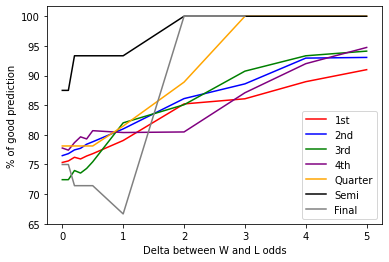

In [17]:
plt.plot(diff,resGS1,color = 'red',label='1st')
plt.plot(diff,resGS2,color = 'blue',label='2nd')
plt.plot(diff,resGS3,color = 'green',label='3rd')
plt.plot(diff,resGS4,color = 'purple',label='4th')
plt.plot(diff,resGS5,color = 'orange',label="Quarter")
plt.plot(diff,resGS6,color = 'black',label='Semi')
plt.plot(diff,resGS7,color = 'gray',label='Final')
plt.xlabel("Delta between W and L odds")
plt.ylabel("% of good prediction")
plt.legend()
plt.show()

### GS gain by match and by round

In [18]:
subdf = sdf[sdf['Round']=="1st Round"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-1.7211045364891526


In [19]:
subdf = sdf[sdf['Round']=="2nd Round"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-2.0293650793650797


In [20]:
subdf = sdf[sdf['Round']=="3rd Round"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-1.0811023622047244


In [21]:
subdf = sdf[sdf['Round']=="4th Round"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-0.8825396825396826


In [22]:
subdf = sdf[sdf['Round']=="Quarterfinals"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-3.7218750000000003


In [23]:
subdf = sdf[sdf['Round']=="Semifinals"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-6.91875


In [24]:
subdf = sdf[sdf['Round']=="The Final"]
subdf = subdf.reset_index(drop=True)

gain = 0
for i in range(subdf.shape[0]):
    if subdf['AvgW'][i]>subdf['AvgL'][i]:
        gain = gain+10*(subdf['AvgW'][i]-1)
    else:
        gain = gain-10
print(gain/subdf.shape[0])

-3.0


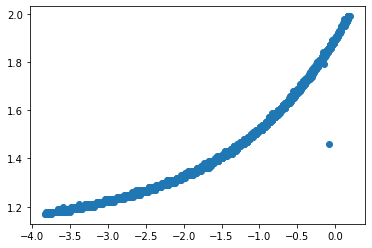

In [25]:
# winning odds vs delta
subdf = df[df['AvgW']<2]
subdf = subdf[subdf['AvgL']<5]
plt.scatter(subdf['AvgW']-subdf['AvgL'],subdf['AvgW'])
#plt.scatter(subdf['AvgW'],subdf['AvgL'])
plt.show()

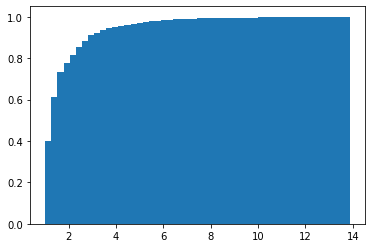

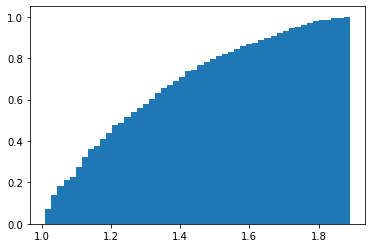

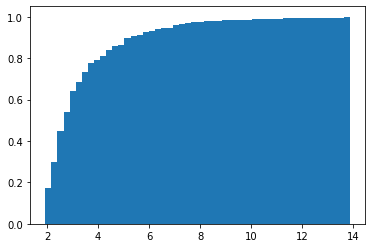

In [26]:
subdf = sdf[sdf['AvgW']<=50]
plt.hist(subdf['AvgW'],bins=50,cumulative=True,density=True)
plt.show()
ok = subdf[subdf['AvgW']<subdf['AvgL']]
plt.hist(ok['AvgW'],bins=50,cumulative=True,density=True)
plt.show()
nok = subdf[subdf['AvgW']>subdf['AvgL']]
plt.hist(nok['AvgW'],bins=50,cumulative=True,density=True)
plt.show()

In [27]:
ok.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W2,L2,...,Lsets,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL,DeltaRank
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,756.000000,756.000000,755.000000,755.000000,...,756.000000,760.000000,760.000000,759.000000,759.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,20.844737,4.997368,38.917105,95.821053,3276.534211,1051.043421,5.854497,4.005291,5.683444,3.821192,...,0.621693,1.297482,6.050500,1.318563,6.974638,1.348737,7.819342,1.297066,5.919237,-56.903947
std,15.265748,0.072548,45.205486,78.865687,3111.093735,1046.262860,1.097857,1.859281,1.247461,1.842924,...,0.743897,0.229044,5.409128,0.243690,6.646988,0.255216,8.214356,0.230813,4.750630,84.754050
min,4.000000,3.000000,1.000000,1.000000,95.000000,10.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.971000,1.900000,0.974000,1.860000,1.010000,2.000000,1.010000,1.920000,-971.000000
25%,5.000000,5.000000,8.000000,51.000000,1078.750000,582.000000,6.000000,3.000000,6.000000,2.000000,...,0.000000,1.110000,2.750000,1.120000,2.875000,1.140000,3.000000,1.100000,2.760000,-86.000000
50%,19.000000,5.000000,21.000000,83.000000,2060.000000,811.000000,6.000000,4.000000,6.000000,4.000000,...,0.000000,1.250000,4.000000,1.270000,4.260000,1.300000,4.500000,1.250000,4.010000,-46.000000
75%,30.000000,5.000000,56.000000,117.000000,4468.000000,1130.000000,6.000000,6.000000,6.000000,6.000000,...,1.000000,1.440000,6.500000,1.480000,7.725000,1.510000,8.125000,1.450000,6.932500,-15.750000
max,49.000000,5.000000,389.000000,1009.000000,12113.000000,11260.000000,7.000000,7.000000,7.000000,7.000000,...,2.000000,1.900000,34.000000,2.050000,37.070000,2.050000,67.000000,1.890000,25.700000,328.000000


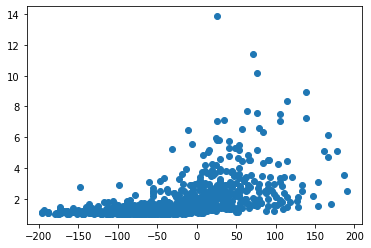

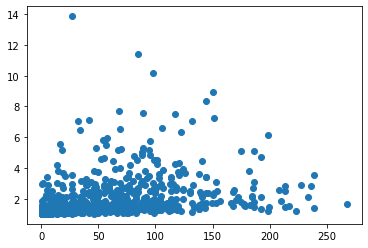

In [28]:
subdf = sdf[abs(sdf['WRank']-sdf['LRank'])<200]
plt.scatter(subdf['DeltaRank'],subdf['AvgW'])
plt.show()
plt.scatter(subdf['WRank'],subdf['AvgW'])
plt.show()

In [142]:
subdf = sdf[sdf['Round']=="1st Round"]
#subdf=sdf

In [143]:
# check probability of losing against higher ranked (theoretically weaker) opponent depending on its own ranking
ranks = [0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300]
win = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
loss = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
labels = ['1-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','200-120','120-140','140-160','160-180','180-200','200-250','350-300']
i=0
for r in range(len(ranks)-1):
    v = subdf.loc[((df['WRank']>ranks[r]) & (subdf['WRank']<=ranks[r+1]) & (subdf['LRank']>ranks[r]))].shape[0]
    l = subdf.loc[((df['LRank']>ranks[r]) & (subdf['LRank']<=ranks[r+1]) & (subdf['WRank']>ranks[r]))].shape[0]
    if v+l>0:
        win[r]=v/(v+l)*100
        loss[r]=l/(v+l)*100

[92.42424242424242, 77.77777777777779, 61.42857142857143, 57.57575757575758, 68.57142857142857, 67.44186046511628, 57.89473684210527, 62.857142857142854, 46.42857142857143, 53.84615384615385, 48.0, 46.15384615384615, 75.0, 100.0, 25.0, 50.0, 0]


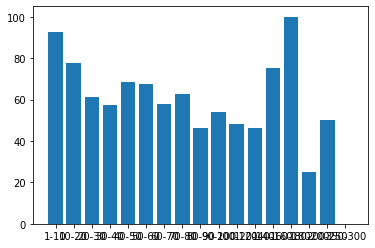

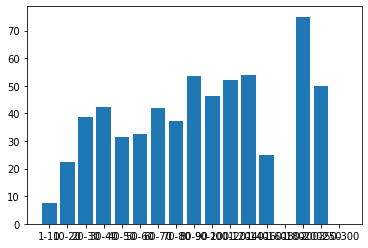

In [144]:
plt.bar(labels,win)
print(win)
plt.show()
plt.bar(labels,loss)
plt.show()

In [59]:
# check probability of losing against higher ranked (theoretically weaker) opponent depending on its own ranking - more than 50
ranks = [0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300]
win = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
loss = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
labels = ['1-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','200-120','120-140','140-160','160-180','180-200','200-250','350-300']
i=0
for r in range(len(ranks)-1):
    v = subdf.loc[((subdf['WRank']>ranks[r]) & (subdf['WRank']<=ranks[r+1]) & (subdf['LRank']>ranks[r+1]+50))].shape[0]
    l = subdf.loc[((subdf['LRank']>ranks[r]) & (subdf['LRank']<=ranks[r+1]) & (subdf['WRank']>ranks[r+1]+50))].shape[0]
    if v+l>0:
        win[r]=v/(v+l)*100
        loss[r]=l/(v+l)*100

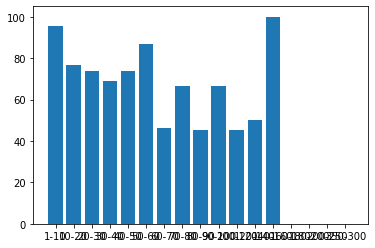

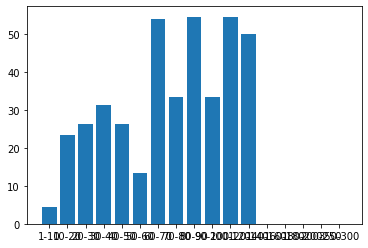

In [60]:
plt.bar(labels,win)
plt.show()
plt.bar(labels,loss)
plt.show()

In [61]:
# check probability of losing against higher ranked (theoretically weaker) opponent depending on its own ranking - more than 100
ranks = [0,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300]
win = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
loss = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
labels = ['1-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','200-120','120-140','140-160','160-180','180-200','200-250','350-300']
i=0
for r in range(len(ranks)-1):
    v = subdf.loc[((subdf['WRank']>ranks[r]) & (subdf['WRank']<=ranks[r+1]) & (subdf['LRank']>ranks[r+1]+100))].shape[0]
    l = subdf.loc[((subdf['LRank']>ranks[r]) & (subdf['LRank']<=ranks[r+1]) & (subdf['WRank']>ranks[r+1]+100))].shape[0]
    if v+l>0:
        win[r]=v/(v+l)*100
        loss[r]=l/(v+l)*100

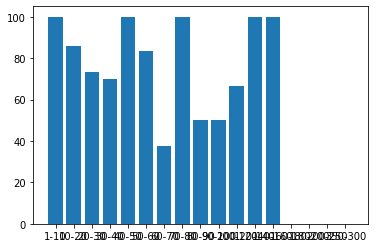

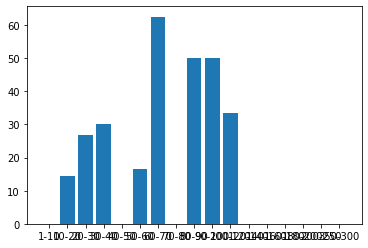

In [62]:
plt.bar(labels,win)
plt.show()
plt.bar(labels,loss)
plt.show()

In [190]:
thr = 10 # threshold for players ranking - 10 means we consider top 10 players
delta = 0 # delta is the ranking difference with the player's opponent - 0 means any player with higher ranking
series = "Grand Slam" # the type of tournament we consider

round = ["1st Round","2nd Round","3rd Round","4th Round","Quarterfinals","Semifinals","The Final"] 
gains = [0,0,0,0,0,0,0]
gainspermatch = [0,0,0,0,0,0,0]
roi = [0,0,0,0,0,0,0]
k=0
for r in round:
    subdf = df.loc[((df['WRank']<=thr) & (df['LRank']>df['WRank']+delta) & (df['Series']==series) & (df['Round']==r))]
    subdf = subdf.reset_index(drop=True)

    gain = 0
    nmatch = subdf.shape[0]
    print("win:",nmatch," average odds:",subdf['AvgW'].mean())
    for i in range(subdf.shape[0]):
        gain = gain+10*(subdf['AvgW'][i]-1)

    subdf = df.loc[((df['LRank']<=thr) & (df['WRank']>df['LRank']+delta) & (df['Series']==series) & (df['Round']==r))]
    print("loss:",subdf.shape[0]," average odds:",subdf['AvgW'].mean())
    nmatch = nmatch+subdf.shape[0]
    gain = gain-10*subdf.shape[0]
    
    gains[k] = gain
    gainspermatch[k] = gain/nmatch
    roi[k] = gain/(nmatch*10)*100
    print("investment:",nmatch*10," gain:",gain," ROI:",roi[k])
    k=k+1

win: 61  average odds: 1.085081967213115
loss: 5  average odds: 5.388
investment: 660  gain: 1.90000000000002  ROI: 0.2878787878787909
win: 59  average odds: 1.0901694915254236
loss: 1  average odds: 4.54
investment: 600  gain: 43.20000000000002  ROI: 7.200000000000002
win: 51  average odds: 1.2090196078431374
loss: 10  average odds: 3.8389999999999995
investment: 610  gain: 6.6000000000000085  ROI: 1.0819672131147555
win: 37  average odds: 1.212162162162162
loss: 11  average odds: 4.3563636363636355
investment: 480  gain: -31.5  ROI: -6.5625
win: 23  average odds: 1.2817391304347827
loss: 5  average odds: 2.728
investment: 280  gain: 14.800000000000011  ROI: 5.28571428571429
win: 16  average odds: 1.444375
loss: 0  average odds: nan
investment: 160  gain: 71.09999999999998  ROI: 44.437499999999986
win: 5  average odds: 1.394
loss: 3  average odds: 2.4266666666666663
investment: 80  gain: -10.299999999999997  ROI: -12.874999999999998


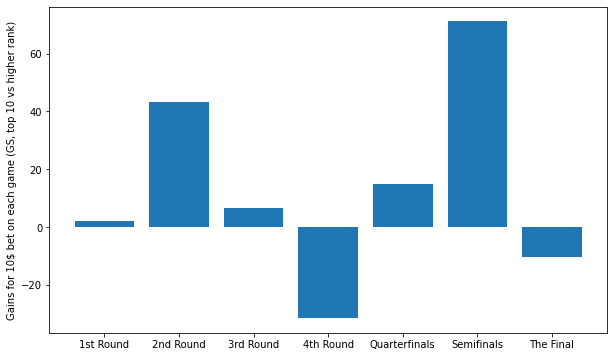

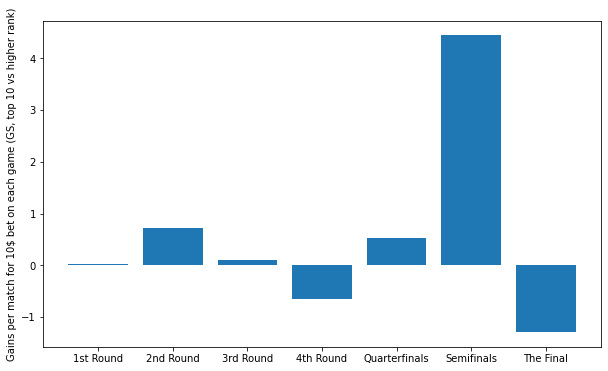

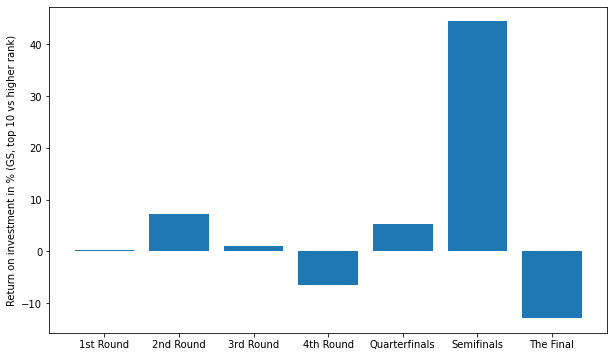

In [192]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.bar(round,gains)
plt.ylabel("Gains for 10$ bet on each game (GS, top 10 vs higher rank)")
plt.show()
plt.bar(round,gainspermatch)
plt.ylabel("Gains per match for 10$ bet on each game (GS, top 10 vs higher rank)")
plt.show()
plt.bar(round,roi)
plt.ylabel("Return on investment in % (GS, top 10 vs higher rank)")
plt.show()